# Policy Gradients in OpenAI Gym: Cartpole

Author: Juvid Aryaman

In [1]:
import gym
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib as mpl
sys.path.append("..")
import utls
utls.reset_plots()

Load the Cartpole environment in `gym`

In [2]:
env = gym.make("CartPole-v0")

## Exploring the Cartpole environment

Let the agent follow a random policy, whereby the action is random for every state the agent finds itself in

In [3]:
state = env.reset()
for t in range(10):
    # show the environment as something a human can understand
    env.render() 
    # execute a random action
    action = 1 # constant policy: go right
    #action = env.action_space.sample() 
    print(state,action)
    state, reward, done, info = env.step(action) 
    if done:
        print("Episode finished after {} timesteps".format(t+1))
        break
print("reward = {}".format(reward))

[-0.01013372  0.0091694  -0.04554989 -0.02321786] 1
[-0.00995034  0.20491398 -0.04601425 -0.32991722] 1
[-0.00585206  0.40065972 -0.05261259 -0.63674847] 1
[ 0.00216114  0.5964744  -0.06534756 -0.94552501] 1
[ 0.01409063  0.79241277 -0.08425806 -1.25800377] 1
[ 0.02993888  0.98850583 -0.10941814 -1.57584244] 1
[ 0.049709    1.18474872 -0.14093499 -1.90055119] 1
[ 0.07340397  1.38108675 -0.17894601 -2.23343608] 1
Episode finished after 8 timesteps
reward = 1.0


## Sigmoid Policy

Use the policy $\sigma(\theta^Ts)$, where $\sigma(x) := 1/(1+e^{-x})$.

In [4]:
theta = np.ones(4)
episodes = 100

reward_all = []
for i in range(episodes):
    state = env.reset()
    reward_tot = 0
    for t in range(1000):
        # show the environment as something a human can understand
        if i == 0:
            env.render() 

        sigma = 1.0/(1.0+np.exp(-np.dot(theta,state)))
        if np.random.uniform() < sigma:
            action = 1 # go right 
        else:
            action = 0

        state, reward, done, info = env.step(action) 
        reward_tot += reward
        if done:        
            break
    reward_all.append(reward_tot)
reward_all = np.array(reward_all)
reward_tot

32.0

In [5]:
reward_all.mean(), reward_all.std(ddof=1)

(25.06, 13.712649914468308)

## Implement REINFORCE algorithm

Policy
$$\pi(a|s,\theta) = p^a (1-p)^{1-a}$$
where 
$$p = \frac{1}{1+e^{-\theta^Ts}}$$
and $\theta, s \in \mathbb{R}^4$ and $a \in \{0,1\}$. Then,
$$ \frac{\partial \pi(a|s,\theta)}{\partial \theta_i} = \frac{s_i (ae^{-\theta^Ts}+a-1)}{1+e^{-\theta^Ts}}$$.

The REINFORCE algorithm is:
1. Initialise policy weights $\theta$
2. Generate an episode $\{s_0,a_0,r_1,\dots,s_{T-1},a_{T-1},r_T\}$ following $\pi(\cdot|\cdot,\theta)$
3. For each time step of the episode $t=0,\dots,T-1$, compute $G_t = \sum_{i=0}^{T-t} \gamma^i r_{t+i}$ and let $\theta \rightarrow \theta + \alpha G_t \nabla_\theta \log \pi(a|s,\theta)$
4. Go back to 2



In [6]:
# def lr_fcn(lr0,k,t):
#     # Learning rate
#     return lr0*np.exp(-k*t)

In [7]:
def smooth_rewards(rewards, bin_length):
    nbins = int(len(rewards)/bin_length)
    mean_reward_binned = []
    std_reward_binned = []
    for i in np.arange(nbins,dtype=int):
        mean_reward = np.mean(rewards[i*bin_length:i*bin_length+bin_length])
        std_reward = np.std(rewards[i*bin_length:i*bin_length+bin_length],ddof=1)
        mean_reward_binned.append(mean_reward)
        std_reward_binned.append(std_reward)
    mean_reward_binned = np.array(mean_reward_binned)
    std_reward_binned = np.array(std_reward_binned)
    return mean_reward_binned, std_reward_binned, nbins

In [28]:
def generate_episode(theta, env, TMAX, render = False):
    """
    Generate an episode from an environment object with a fixed sigmoid policy 
    
    Params:
        theta : A numpy vector, the parameters of the policy
        env : A gym environment object
        TMAX : An int, maximum amount of time to run a session
        render : A bool, whether or not to render the environment
        
    Returns:
        state_episode : A numpy list of the states in the episode
        action_episode: A numpy list of the actions in the episode
        reward_episode: A numpy list of the rewards in the episode
    """
    state = env.reset() # initial state
    state_episode = []
    action_episode = []
    reward_episode = []
    
    for t in range(TMAX):
        # Sigmoid policy
        sigma = 1.0/(1.0+np.exp(-np.dot(theta,state)))
        if np.random.uniform() < sigma:
            action = 1 # go right 
        else:
            action = 0
        if render:
            env.render() 
        state_new, reward, done, info = env.step(action) 
        
        # Save
        state_episode.append(state) # old state
        action_episode.append(action)
        reward_episode.append(reward)
        
        # Update
        state = state_new # update state        
        
        if done:        
            break
    state_episode.append(state_new) # append the final state
    
    state_episode = np.array(state_episode)
    action_episode = np.array(action_episode)
    reward_episode = np.array(reward_episode)
    
    return state_episode, action_episode, reward_episode

In [18]:
episodes = 1000
gamma = 0.99
# alpha_hl = np.log(2)/(episodes/0.01)
# alpha0 = 0.1
alpha = 0.005

In [19]:
# t = np.arange(episodes)
# fig, ax = plt.subplots(1,1)
# ax.plot(t,lr_fcn(alpha0,alpha_hl,t), '-k')
# #utls.remove_tex_axis(ax, ytick_fmt="%.4f")
# ax.set_xlabel('Time')
# ax.set_ylabel(r'$\alpha$');

In [20]:
theta = np.random.normal(1,0.1,size=4) 
TMAX = 250

reward_all = []

for ep in range(episodes):
    if ep % 100 == 0: print(ep)
    
    # Make an episode
    state_ep, action_ep, rewards_ep =  generate_episode(theta, env, TMAX)
    
    reward_all.append(np.sum(rewards_ep)) # sum the reward from the episode
    
    # Retroactively update theta according to REINFORCE update rule
    #alpha = lr_fcn(alpha0,alpha_hl,ep) 
    
    T = len(action_ep)
    for i in range(T):
        si = state_ep[i,:]
        ai = action_ep[i]
        x = np.exp(-np.dot(theta, si))
        
        grad_log_pi = si*(ai*x + ai - 1.0)/(1.0+x)        
        discounted_return = np.sum([rewards_ep[i+j+1]*gamma**j for j in range(T-i-1)])        
        theta = theta + alpha*grad_log_pi*discounted_return

reward_all = np.array(reward_all)
        

0
100
200
300
400
500
600
700
800
900


In [21]:
reward_all.mean(), reward_all.std(ddof=1)

(191.183, 27.211982709883582)

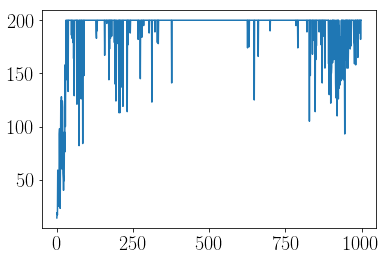

In [22]:
plt.plot(np.arange(len(reward_all)),reward_all)

In [23]:
mean_reward_binned, std_reward_binned, nbins = smooth_rewards(reward_all, bin_length=50)

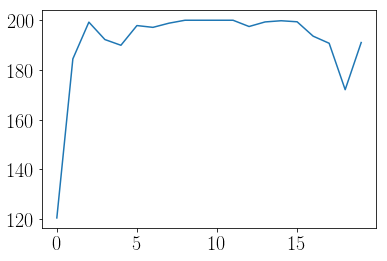

In [24]:
plt.plot(np.arange(nbins), mean_reward_binned)

In [33]:
_ = generate_episode(theta, env, TMAX, render = True)

Awesome.